In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster
import scipy

import folium
import geopy

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("Lesson_5.csv")

In [3]:
del df["State/Province"]
del df["Postcode"]
del df["Phone Number"]
del df["Store Name"]

In [4]:
df = df.drop(np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0])

In [5]:
df.set_index(df["Store Number"], inplace = True)

In [6]:
df.fillna("No_data", inplace = True)

In [7]:
df["Revenue"] = np.random.randint(low=150000, high=250000, size=len(df))
df["Cost"] = np.random.randint(low=120000, high=210000, size=len(df))
df["Satisfaction"] = np.random.choice(["Very_satisfied", "Satisfied", "Neither", "Dissatisfied", "Very dissatisfied"], size=len(df), p=[0.4,0.4,0.1,0.07, 0.03])

In [8]:
city = "Moscow"

locator = geopy.geocoders.Nominatim(user_agent="Lesson_5_HW")
location = locator.geocode(city)
location = [location.latitude, location.longitude]

In [9]:
df.head()

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
47370-257954,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51,163035,122072,Satisfied
22331-212325,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42,245262,126389,Dissatisfied
47089-256771,Starbucks,47089-256771,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39,163246,198081,Satisfied
22126-218024,Starbucks,22126-218024,Licensed,Al Salam Street,Abu Dhabi,AE,GMT+04:00 Asia/Dubai,54.38,24.48,177432,199732,Satisfied
17127-178586,Starbucks,17127-178586,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AE,GMT+04:00 Asia/Dubai,54.54,24.51,187445,196568,Very_satisfied


In [10]:
Russia_df = df.loc[df['Country'] == "RU"]

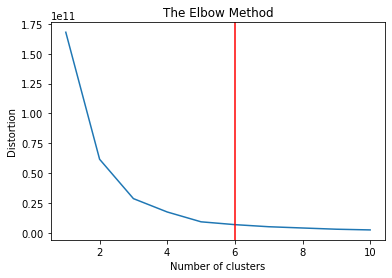

In [11]:
Russia_df['Profit'] = Russia_df['Revenue'] - Russia_df['Cost']
Russia_df['Satisfaction'] = Russia_df['Satisfaction'].map({"Very_satisfied": 10, "Satisfied":6, "Neither" : 4, "Dissatisfied": 2, "Very dissatisfied": 1})

X = Russia_df[["Satisfaction","Profit"]]
max_k = 10


distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_)
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))


fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

In [33]:
k = 5
model = KMeans(n_clusters=k)

X = Russia_df[["Satisfaction","Profit"]]
Russia_df["cluster"] = model.fit_predict(X)

In [34]:
new_map = folium.Map(location=location, zoom_start=2)

In [36]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Russia_df["size"] = scaler.fit_transform(Russia_df["Revenue"].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5:"black", 6:"grey"}

for index, row in Russia_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(new_map)

In [37]:
new_map

In [38]:
columns = ["Cluster", "Average_Revenue", "Sum_Revenue", "Average_Profit", "Sum_Profit", "Average_Satisfaction"]
result_df = pd.DataFrame(columns = columns)
for i in set(Russia_df['cluster']):
    cluster_df = Russia_df.loc[Russia_df['cluster'] == i]
    result_df.loc[i] = [i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]
 

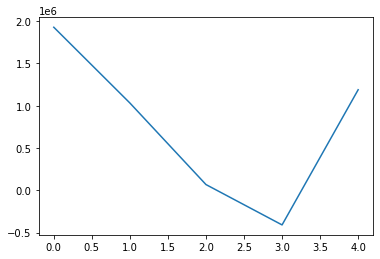

In [39]:
plt.plot(result_df["Cluster"], result_df["Sum_Profit"])

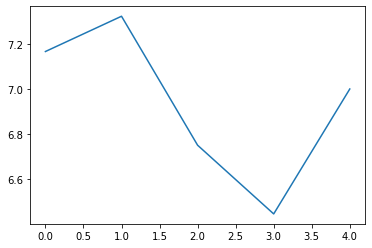

In [40]:
plt.plot(result_df["Cluster"], result_df["Average_Satisfaction"])

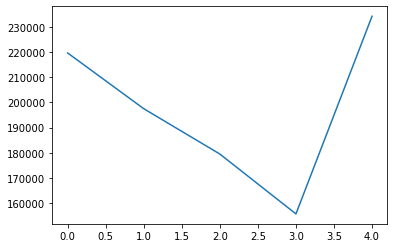

In [41]:
plt.plot(result_df["Cluster"], result_df["Average_Revenue"])

#### До оптимизации

In [42]:
print("Выручка сети: %.2f  " % Russia_df["Revenue"].sum())
print("Прибыль сети: %.2f " % Russia_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % Russia_df["Satisfaction"].mean())

Выручка сети: 21821477.00  
Прибыль сети: 3808439.00 
Средняя удовлетворенность клиента: 7.05 


#### После оптимизации

In [43]:
after_optimisation_df = Russia_df.loc[Russia_df["cluster"] != 3]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 20419592.00 
Прибыль сети: 4217276.00 
Средняя удовлетворенность клиента: 7.10 


In [44]:
after_optimisation_df = Russia_df.loc[Russia_df["cluster"] != 0]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 15234163.00 
Прибыль сети: 1880647.00 
Средняя удовлетворенность клиента: 7.00 
